<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import glob
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


     |████████████████████████████████| 77 kB 2.8 MB/s 


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


# Data preprocessing

Train data available at: https://drive.google.com/file/d/1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G

Test data available at: https://drive.google.com/file/d/1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y

## Dimension
(No. files x width x height x channels)

Size of train data: 200 000 x 180 x 60 x 3

Size of test data: 50 000 x 180 x 60 x 3

In [3]:
# download files from google drive

# load train data
!gdown --id 1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
# load test data
!gdown --id 1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y


Downloading...
From: https://drive.google.com/uc?id=1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
To: /content/captcha_train.tar.gz
100% 1.92G/1.92G [00:16<00:00, 100MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y
To: /content/captcha_test.tar.gz
100% 480M/480M [00:05<00:00, 86.9MB/s]


In [4]:
# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

In [5]:
# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

In [6]:
# check number of files
train_labels = os.listdir('train/train')
print('train files:', len(train_labels))

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

train files: 199987
test files: 49998


In [7]:
# check distribution of symbols in train set

# these are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits 

index = {}
for cha in symbols:
  index[cha] = 0


In [8]:
for item in train_labels:
  get_label = str(item).split('.')[0]
  for cha in get_label:
    index[cha] += 1

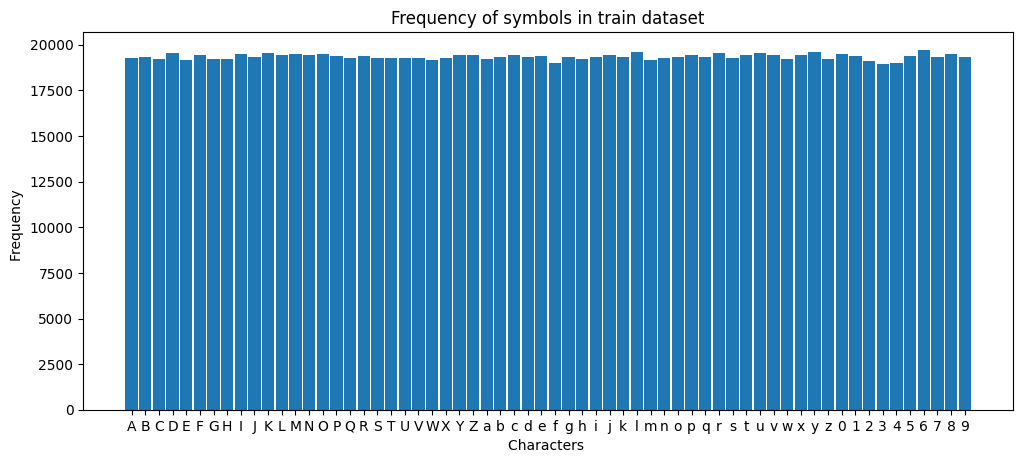

In [9]:
plt.figure(num=None, figsize=(12, 5), dpi=100, facecolor='w', edgecolor='k')
plt.bar(index.keys(), index.values(), width=0.9)
plt.title('Frequency of symbols in train dataset')
plt.xlabel("Characters ", fontsize=10)  
plt.ylabel("Frequency  ", fontsize=10)
plt.show()

## Create Data Loader

In [10]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 128                       # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [11]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [12]:
# create dataloaders

dataset_train = Custom_Dataset('train/train', train_labels) 
dataset_test = Custom_Dataset('test/test', test_labels)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=False)

print(len(train_loader), len(test_loader))

1563 391


In [13]:
# check dimensions
print(len(train_labels)/batch_size, len(test_labels)/batch_size)

1562.3984375 390.609375


In [14]:
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

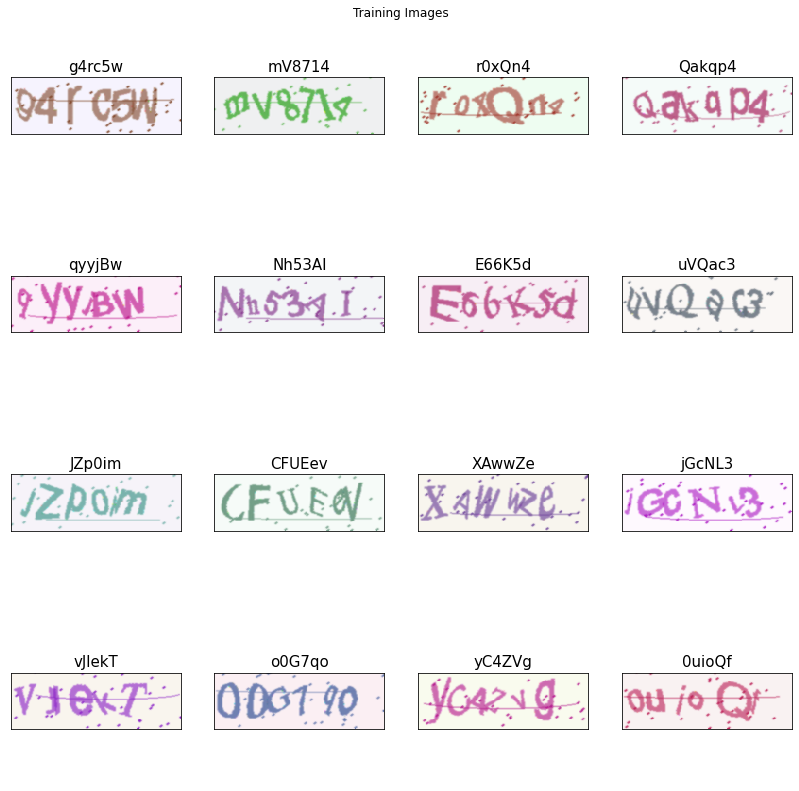

In [16]:
# view some train images
real_batch = next(iter(train_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

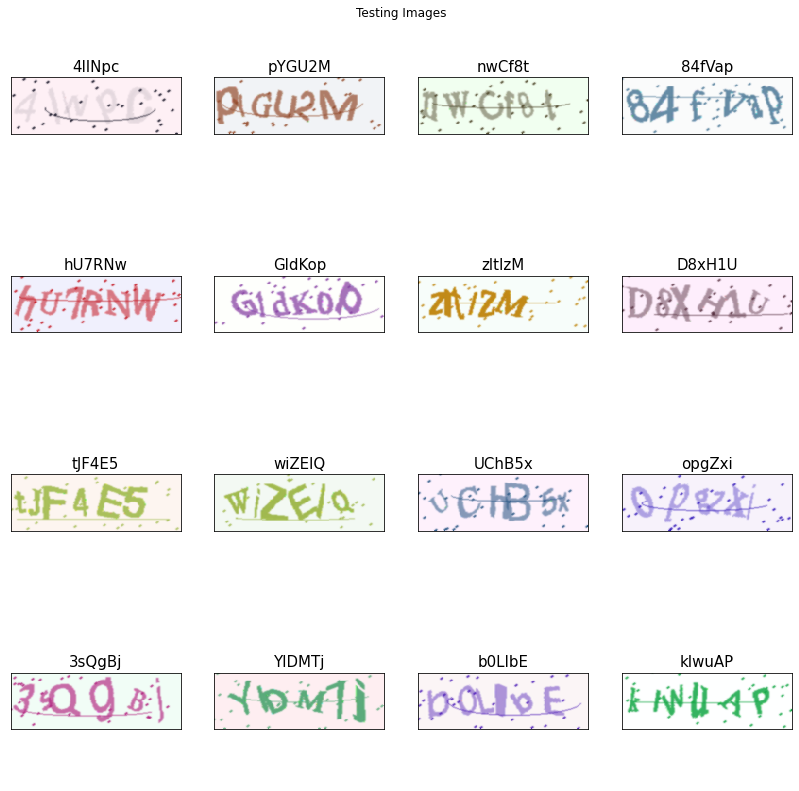

In [17]:
# view some test images
real_batch = next(iter(test_loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

# Creating model

In [18]:
print(symbols)

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789


In [19]:
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
print(symbols_char)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'a', 27: 'b', 28: 'c', 29: 'd', 30: 'e', 31: 'f', 32: 'g', 33: 'h', 34: 'i', 35: 'j', 36: 'k', 37: 'l', 38: 'm', 39: 'n', 40: 'o', 41: 'p', 42: 'q', 43: 'r', 44: 's', 45: 't', 46: 'u', 47: 'v', 48: 'w', 49: 'x', 50: 'y', 51: 'z', 52: '0', 53: '1', 54: '2', 55: '3', 56: '4', 57: '5', 58: '6', 59: '7', 60: '8', 61: '9'}


In [20]:
symbols_idx = {v:k for k,v in symbols_char.items()}
print(symbols_idx)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'a': 26, 'b': 27, 'c': 28, 'd': 29, 'e': 30, 'f': 31, 'g': 32, 'h': 33, 'i': 34, 'j': 35, 'k': 36, 'l': 37, 'm': 38, 'n': 39, 'o': 40, 'p': 41, 'q': 42, 'r': 43, 's': 44, 't': 45, 'u': 46, 'v': 47, 'w': 48, 'x': 49, 'y': 50, 'z': 51, '0': 52, '1': 53, '2': 54, '3': 55, '4': 56, '5': 57, '6': 58, '7': 59, '8': 60, '9': 61}


In [21]:
num_symbols = len(symbols_idx)
print(num_symbols)


62


## Define model with resnet 18

In [22]:
rnn_hidden_size = 256

In [23]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [24]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [25]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [26]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [27]:
ctc

CTC(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [28]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([128, 3, 60, 180]) ('6NRR1w', '1oaxXk', '1dkzyO', 'DgXZS3', 'Lj1x5c', 'KEJLIF', 'Q7nRLJ', 'vLPzCo', 'rUl7kA', 'IZNe9y', 'sxeTUA', 'orlRw1', '5x6EwX', 'yPNjRR', 'o46jFs', 'gqw4hw', '99ufTQ', 'oq2V8L', 'u4Ga5Y', 'vj7I1A', '4Ut1ES', 'NsVdLp', 'gVUaaE', 'ToLoS2', 'cmqmCc', '608a2H', 'HAXc8V', 'RxCa8H', 'mhI3Ga', 'QM6HCn', 'vD6ZHv', '0qKBq6', '6d58ty', 'ZHNJfy', 'FMvkgt', '31AWFR', 'JFLH1h', 'rDOlUS', '4E79Ys', 'oMGZiq', 'yHXwer', 'li4VwM', 'qlrEXu', 'O4rRbo', 'VpcOsA', 'RfcrxR', 'A1zL9x', 'tbSvA7', 'tj4pnP', 'vNo9t4', '9Ki8jt', 'Ln3YBZ', '6q92jD', 'ZhJfG0', 'thGEsK', 'DWO9Gg', 'XSVGLF', 'ul5LMD', 'sUhPcp', 'DxeseL', 'bR6ub3', 'za56gA', 'lICHwr', '5pxsf3', 'cmiduU', 'lWfJzz', 'ay8OdQ', '3Makr7', 'NuDmAl', 'KhgSji', '91eFLJ', 'JScYE9', 'yPSrX7', 'opQs10', '6n7Rzl', 'Dy9Tpk', 'JJp5XV', 'faxX16', 'NxZ8zA', 'E8I1t3', 'JbhPUi', 'KIe9Il', 'OdzawW', 'fxYAJ2', 'enC8Z7', 'FZYWHh', 'ycIT2B', 'TGWdIP', 'KebCB0', 'Zha6Jy', 'U7luxf', 'QM8oVI', '1m2xK3', 'O7qGYo', 'gzwlyU', 'RrIE9p', 'IAIcd8',

In [29]:
text_batch_logits = ctc(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('6NRR1w', '1oaxXk', '1dkzyO', 'DgXZS3', 'Lj1x5c', 'KEJLIF', 'Q7nRLJ', 'vLPzCo', 'rUl7kA', 'IZNe9y', 'sxeTUA', 'orlRw1', '5x6EwX', 'yPNjRR', 'o46jFs', 'gqw4hw', '99ufTQ', 'oq2V8L', 'u4Ga5Y', 'vj7I1A', '4Ut1ES', 'NsVdLp', 'gVUaaE', 'ToLoS2', 'cmqmCc', '608a2H', 'HAXc8V', 'RxCa8H', 'mhI3Ga', 'QM6HCn', 'vD6ZHv', '0qKBq6', '6d58ty', 'ZHNJfy', 'FMvkgt', '31AWFR', 'JFLH1h', 'rDOlUS', '4E79Ys', 'oMGZiq', 'yHXwer', 'li4VwM', 'qlrEXu', 'O4rRbo', 'VpcOsA', 'RfcrxR', 'A1zL9x', 'tbSvA7', 'tj4pnP', 'vNo9t4', '9Ki8jt', 'Ln3YBZ', '6q92jD', 'ZhJfG0', 'thGEsK', 'DWO9Gg', 'XSVGLF', 'ul5LMD', 'sUhPcp', 'DxeseL', 'bR6ub3', 'za56gA', 'lICHwr', '5pxsf3', 'cmiduU', 'lWfJzz', 'ay8OdQ', '3Makr7', 'NuDmAl', 'KhgSji', '91eFLJ', 'JScYE9', 'yPSrX7', 'opQs10', '6n7Rzl', 'Dy9Tpk', 'JJp5XV', 'faxX16', 'NxZ8zA', 'E8I1t3', 'JbhPUi', 'KIe9Il', 'OdzawW', 'fxYAJ2', 'enC8Z7', 'FZYWHh', 'ycIT2B', 'TGWdIP', 'KebCB0', 'Zha6Jy', 'U7luxf', 'QM8oVI', '1m2xK3', 'O7qGYo', 'gzwlyU', 'RrIE9p', 'IAIcd8', 'msElNz', 'XTGyvx', 'M0Ufyr',

## Define loss

In [30]:
criterion = nn.CTCLoss(blank=0)

In [31]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [32]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [33]:
text_batch_logits.shape

torch.Size([9, 128, 62])

In [34]:
compute_loss(text_batch, text_batch_logits)

tensor(5.2919, device='cuda:0', grad_fn=<MeanBackward0>)

## Train model

In [44]:
num_epochs = 10
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [45]:
optimizer = optim.Adam(ctc.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [46]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [47]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in train_loader:
        optimizer.zero_grad()
        text_batch_logits = ctc(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(ctc.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

 10%|█         | 1/10 [09:08<1:22:17, 548.57s/it]

Epoch:1    Loss:2.845610250514513    NumUpdates:1563


 20%|██        | 2/10 [18:16<1:13:03, 547.92s/it]

Epoch:2    Loss:2.564985384028917    NumUpdates:1563


 30%|███       | 3/10 [27:22<1:03:50, 547.27s/it]

Epoch:3    Loss:2.5119543920628016    NumUpdates:1563


 40%|████      | 4/10 [36:27<54:39, 546.53s/it]  

Epoch:4    Loss:2.4938778793361807    NumUpdates:1563


 50%|█████     | 5/10 [45:31<45:28, 545.61s/it]

Epoch:5    Loss:2.4773589474073376    NumUpdates:1563


 60%|██████    | 6/10 [54:35<36:19, 544.86s/it]

Epoch:6    Loss:2.471767200236891    NumUpdates:1563


 70%|███████   | 7/10 [1:03:39<27:13, 544.58s/it]

Epoch:7    Loss:2.4755590524874815    NumUpdates:1563


 80%|████████  | 8/10 [1:12:42<18:08, 544.05s/it]

Epoch:8    Loss:2.464469761857602    NumUpdates:1563


 90%|█████████ | 9/10 [1:21:43<09:03, 543.25s/it]

Epoch:9    Loss:2.460938419353024    NumUpdates:1563


100%|██████████| 10/10 [1:30:45<00:00, 544.51s/it]

Epoch:10    Loss:2.4627571970853603    NumUpdates:1563


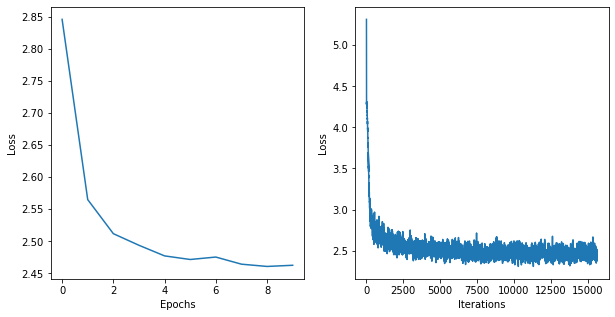

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## Make predictions

In [49]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [50]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

100%|██████████| 1563/1563 [04:29<00:00,  5.80it/s]


In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
print(results_train.shape)
results_train.head()

In [ ]:
print(results_test.shape)
results_test.head()

In [54]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

In [56]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,4IlNpc,4AAAppppp,4Ap
1,pYGU2M,pGGUUU2MM,pGU2M
2,nwCf8t,nnwCC8888,nwC8
3,84fVap,884fffVVa,84fVa
4,hU7RNw,hU777RNNw,hU7RNw


# Evaluate model

In [57]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,4IlNpc,4AAAppppp,4Ap
1,pYGU2M,pGGUUU2MM,pGU2M
2,nwCf8t,nnwCC8888,nwC8
3,84fVap,884fffVVa,84fVa
5,GldKop,GGGddKKpp,GdKp
...,...,...,...
49992,ew1t5B,ew1111BBB,ew1B
49993,tGonzT,ttGGnnnTT,tGnT
49994,uQF0GR,uuQFFGGGR,uQFGR
49995,XopZMb,XXppZZMMb,XpZMb


In [58]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

5    20633
4    18741
3     4783
6     1049
2      443
1       26
7       13
Name: prediction_corrected, dtype: int64


In [59]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
1,pYGU2M,pGGUUU2MM,pGU2M
3,84fVap,884fffVVa,84fVa
6,zltIzM,zrtjMMMMM,zrtjM
7,D8xH1U,D888HHH1U,D8H1U
8,tJF4E5,JJFF44E55,JF4E5
...,...,...,...
49986,prtqHp,prrqqHHpp,prqHp
49987,w8GNoD,888GNNoDD,8GNoD
49990,t1v8Bz,ttVV888Bz,tV8Bz
49994,uQF0GR,uuQFFGGGR,uQFGR


In [60]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.08769570022051433
0.08620344813792552


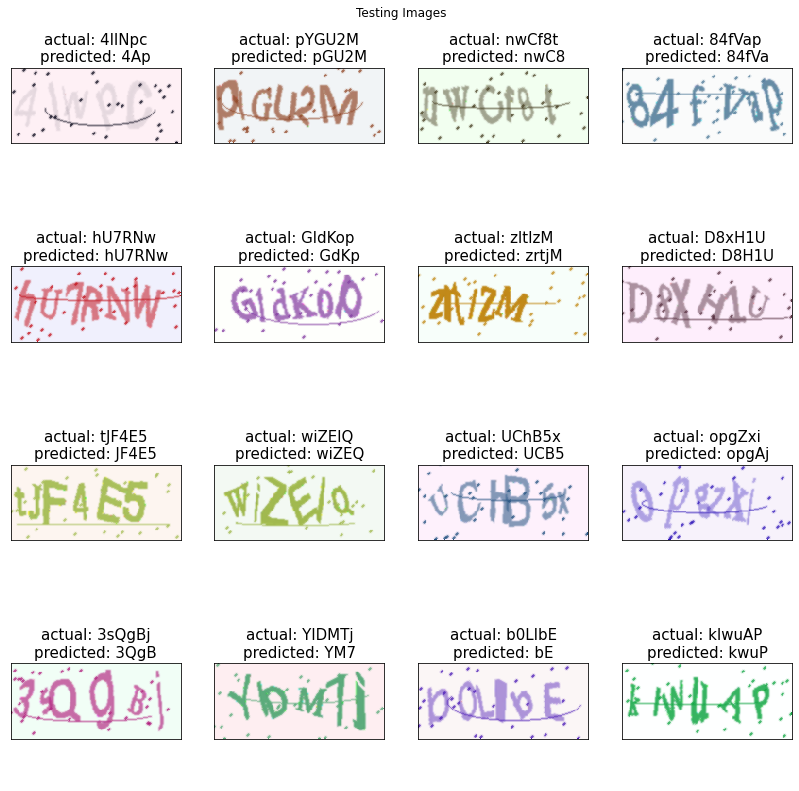

In [82]:
# view some test images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    result = results_test.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('test/test/{}.png'.format(result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)